# Setup

In [ ]:
import os

import torch
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, random_split
# from torchvision.transforms import functional as F
from torch.nn import functional as F
from pycocotools.coco import COCO
import torchvision.transforms.v2 as T
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import transforms

import matplotlib.pyplot as plt
from itertools import cycle

from tqdm.notebook import tqdm

import random
import numpy as np

import wandb

In [ ]:
wandb.login()

wandb: Currently logged in as: fejowo5522 (fejowo5522-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# reduce cpu contention
torch.set_num_threads(1)
NUM_WORKERS = 6  # adjust based on CPU cores

cuda


In [ ]:
COCO_PATH = "./data/coco/"  # change this
IMG_DIR_TRAIN = os.path.join(COCO_PATH, "images/train2017")
IMG_DIR_VAL = os.path.join(COCO_PATH, "images/val2017")
ANN_FILE_TRAIN = os.path.join(COCO_PATH, "annotations/person_keypoints_train2017.json")
ANN_FILE_VAL = os.path.join(COCO_PATH, "annotations/person_keypoints_val2017.json")

REMOVE_IMAGES_WITHOUT_KEYPOINTS = True
VAL_SPLIT = 0.5
TEST_VAL_TRAIN_PERCENT = (0.1, 0.1, 0.1)
BATCH_SIZE = 128

NUM_KEYPOINTS = 17
MAX_PERSONS = 5

# Data

In [ ]:
class CustomTransform:
    def __init__(self, size=(256, 256), augmentation=False):
        val_transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            T.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])
        ])

        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if augmentation:
            self.transform = train_transform
        else:
            self.transform = val_transform

    
    def __call__(self, image, target):
        return self.transform(image), target


In [ ]:
class CocoKeypointsDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None, filter_without_keypoints=True):
        super().__init__(img_folder, ann_file)
        self.coco = COCO(ann_file)
        self._transforms = transforms
        self.filter_without_keypoints = filter_without_keypoints

        if self.filter_without_keypoints:
            # Save the original ids before filtering
            original_ids = list(self.ids)  # Use self.ids after super().__init__
            self.ids = []
            for img_id in original_ids:
                ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
                anns = self.coco.loadAnns(ann_ids)
                anns_with_kp = [ann for ann in anns if 'keypoints' in ann and np.any(np.array(ann['keypoints']) != 0)]
                if len(anns_with_kp) > 0:
                    self.ids.append(img_id)

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        orig_w, orig_h = img.size  # PIL image size (width, height)
        ann_ids = self.coco.getAnnIds(imgIds=self.ids[idx], iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        if self.filter_without_keypoints:
            # Filter for annotations with keypoints
            anns = [ann for ann in anns if 'keypoints' in ann and np.any(np.array(ann['keypoints']) != 0)]
        else:
            anns = [ann for ann in anns if 'keypoints' in ann]

        target = {
            "image_id": self.ids[idx],
            "annotations": anns,
            "orig_size": (orig_w, orig_h)
        }
        if self._transforms:
            img, target = self._transforms(img, target)
        return img, target


In [ ]:
def coco_collate_fn(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack([img for img in imgs])
    batch_size = len(imgs)
    keypoints_tensor = torch.zeros((batch_size, MAX_PERSONS, NUM_KEYPOINTS, 3), dtype=torch.float32)
    for i, t in enumerate(targets):
        anns = t['annotations']
        orig_w, orig_h = t['orig_size']
        for j, ann in enumerate(anns[:MAX_PERSONS]):
            kp = torch.tensor(ann['keypoints']).view(NUM_KEYPOINTS, 3).float()
            kp[:, 0] = kp[:, 0] * (256.0 / orig_w)
            kp[:, 1] = kp[:, 1] * (256.0 / orig_h)
            keypoints_tensor[i, j] = kp
    return imgs, keypoints_tensor

In [ ]:
train_dataset = CocoKeypointsDataset(
    IMG_DIR_TRAIN, 
    ANN_FILE_TRAIN, 
    transforms=CustomTransform(), 
    filter_without_keypoints=REMOVE_IMAGES_WITHOUT_KEYPOINTS
)
val_dataset = CocoKeypointsDataset(
    IMG_DIR_VAL, 
    ANN_FILE_VAL, 
    transforms=CustomTransform(), 
    filter_without_keypoints=REMOVE_IMAGES_WITHOUT_KEYPOINTS
)

val_size = int(VAL_SPLIT * len(val_dataset))
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])


loading annotations into memory...
Done (t=7.53s)
creating index...
index created!
loading annotations into memory...
Done (t=7.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [ ]:
print("train dataset size:", len(train_dataset))
print("val dataset size:", len(val_dataset))
print("test dataset size:", len(test_dataset))

train dataset size: 56599
val dataset size: 1173
test dataset size: 1173


In [ ]:
subset_len_train = int(TEST_VAL_TRAIN_PERCENT[0] * len(train_dataset))
subset_len_val = int(TEST_VAL_TRAIN_PERCENT[1] * len(val_dataset))
subset_len_test = int(TEST_VAL_TRAIN_PERCENT[2] * len(test_dataset))

train_dataset = torch.utils.data.Subset(train_dataset, range(subset_len_train))
val_dataset = torch.utils.data.Subset(val_dataset, range(subset_len_val))
test_dataset = torch.utils.data.Subset(test_dataset, range(subset_len_test))

In [ ]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=coco_collate_fn, 
    pin_memory=True,            # faster GPU transfer
    # persistent_workers=True     # maintain worker pool
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=coco_collate_fn, 
    pin_memory=True,
    # persistent_workers=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=coco_collate_fn, 
    pin_memory=True,
    # persistent_workers=True
)

In [ ]:
print("train dataset size:", len(train_dataset))
print("val dataset size:", len(val_dataset))
print("test dataset size:", len(test_dataset))

train dataset size: 5659
val dataset size: 117
test dataset size: 117


## Visualize data

In [ ]:
def visualize_prediction(img_tensor, keypoints_tensor):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    colors = cycle(plt.cm.tab10.colors)
    # Plot GT keypoints for all persons
    for i, kp in enumerate(keypoints_tensor):
        kp = kp.cpu().numpy()
        if np.all(kp == 0):
            continue
        color = next(colors)
        plt.scatter(kp[:, 0], kp[:, 1], color=color, label=f'GT {i+1}')
    plt.show()

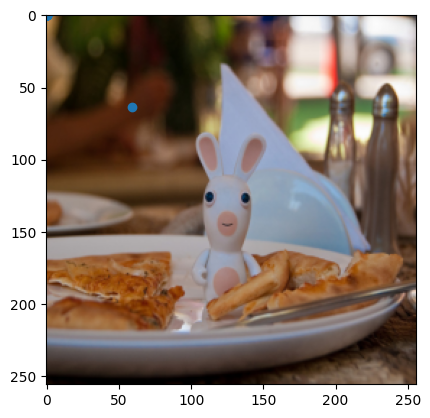

Person 1 keypoints:
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [58.8000, 63.5077,  2.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])
Person 2 keypoints:
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],


In [ ]:
imgs, targets = next(iter(test_loader))

if 'test_iter' not in globals():
    test_iter = iter(test_loader)
    
try:
    imgs, targets = next(test_iter)
except StopIteration:
    test_iter = iter(test_loader)
    imgs, targets = next(test_iter)

imgs = imgs.to(device)


idx = random.randint(0, imgs.shape[0] - 1)
img = imgs[idx].cpu()
keypoints = targets[idx]  # (MAX_PERSONS, 17, 3)

visualize_prediction(img, keypoints)


for i, kp in enumerate(keypoints):
    print(f"Person {i+1} keypoints:\n{kp}")

# Model

In [ ]:
# MODEL_NAME = "ResNet18"

# class KeypointModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.backbone = resnet18(pretrained=True)
#         # Output: (batch, MAX_PERSONS * NUM_KEYPOINTS * 3)
#         self.backbone.fc = nn.Linear(self.backbone.fc.in_features, MAX_PERSONS * NUM_KEYPOINTS * 3)

#     def forward(self, x):
#         # x = self.backbone(x)

#         # # Reshape to (batch, MAX_PERSONS, NUM_KEYPOINTS, 3)
#         # x = x.view(x.size(0), MAX_PERSONS, NUM_KEYPOINTS, 3)

#         # # Apply sigmoid to visibility logit (last channel)
#         # coords = x[..., :2]  # (x, y)
#         # visibility_logit = x[..., 2]  # (logit)
#         # visibility = torch.sigmoid(visibility_logit)

#         # # Concatenate coords and visibility along last dim
#         # out = torch.cat([coords, visibility.unsqueeze(-1)], dim=-1)

#         # return out

#         x = self.backbone(x)
#         return x.view(x.size(0), MAX_PERSONS, NUM_KEYPOINTS, 3)  # Raw logits


In [ ]:
from torchvision.models import resnet18

MODEL_NAME = "Pretrained UNet"

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class KeypointModel(nn.Module):
    def __init__(self, out_channels=MAX_PERSONS * NUM_KEYPOINTS * 3):
        super().__init__()
        resnet = resnet18(weights="IMAGENET1K_V1")
        self.input_block = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
        )
        self.enc1 = resnet.layer1
        self.enc2 = resnet.layer2
        self.enc3 = resnet.layer3
        self.enc4 = resnet.layer4

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = UNetBlock(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = UNetBlock(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = UNetBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = UNetBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = UNetBlock(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        x1 = self.input_block(x)      # 64
        x2 = self.enc1(x1)            # 64
        x3 = self.enc2(x2)            # 128
        x4 = self.enc3(x3)            # 256
        x5 = self.enc4(x4)            # 512

        bottleneck = self.bottleneck(self.pool(x5))

        d4 = self.up4(bottleneck)
        d4 = torch.cat([d4, x5], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, x4], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, x3], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, x2], dim=1)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(
            x.size(0), MAX_PERSONS, NUM_KEYPOINTS, 3
        )
        return out

In [ ]:
# MODEL_NAME = "UNet"

# class UNetBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.conv(x)

# class KeypointModel(nn.Module):
#     def __init__(self, in_channels=3, out_channels=MAX_PERSONS * NUM_KEYPOINTS * 3):
#         super().__init__()
#         self.enc1 = UNetBlock(in_channels, 64)
#         self.enc2 = UNetBlock(64, 128)
#         self.enc3 = UNetBlock(128, 256)
#         self.enc4 = UNetBlock(256, 512)

#         self.pool = nn.MaxPool2d(2)

#         self.bottleneck = UNetBlock(512, 1024)

#         self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
#         self.dec4 = UNetBlock(1024, 512)
#         self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
#         self.dec3 = UNetBlock(512, 256)
#         self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
#         self.dec2 = UNetBlock(256, 128)
#         self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
#         self.dec1 = UNetBlock(128, 64)

#         self.final_conv = nn.Conv2d(64, out_channels, 1)

#     def forward(self, x):
#         enc1 = self.enc1(x)
#         enc2 = self.enc2(self.pool(enc1))
#         enc3 = self.enc3(self.pool(enc2))
#         enc4 = self.enc4(self.pool(enc3))

#         bottleneck = self.bottleneck(self.pool(enc4))

#         dec4 = self.up4(bottleneck)
#         dec4 = torch.cat([dec4, enc4], dim=1)
#         dec4 = self.dec4(dec4)

#         dec3 = self.up3(dec4)
#         dec3 = torch.cat([dec3, enc3], dim=1)
#         dec3 = self.dec3(dec3)

#         dec2 = self.up2(dec3)
#         dec2 = torch.cat([dec2, enc2], dim=1)
#         dec2 = self.dec2(dec2)

#         dec1 = self.up1(dec2)
#         dec1 = torch.cat([dec1, enc1], dim=1)
#         dec1 = self.dec1(dec1)

#         out = self.final_conv(dec1)
#         # Output shape: (batch, MAX_PERSONS * NUM_KEYPOINTS * 3, H, W)
#         # For keypoint regression, we can flatten spatial dims and use a linear layer if needed.
#         # Here, we global average pool and reshape to (batch, MAX_PERSONS, NUM_KEYPOINTS, 3)
#         out = F.adaptive_avg_pool2d(out, (1, 1)).view(
#             x.size(0), MAX_PERSONS, NUM_KEYPOINTS, 3
#         )
#         return out

In [ ]:
# MODEL_NAME = "AlexNet"

# class KeypointModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             # Output: (MAX_PERSONS, NUM_KEYPOINTS, 3) where 3 = (x, y, visibility)
#             nn.Linear(4096, MAX_PERSONS * NUM_KEYPOINTS * 3),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         x = x.view(x.size(0), MAX_PERSONS, NUM_KEYPOINTS, 3)
#         return x

In [ ]:
def keypoint_loss(preds, targets):
    # Coordinates: L1 loss
    coord_mask = (targets[..., 2] > 0)  # only compute for visible keypoints
    coord_loss = F.l1_loss(
        preds[..., :2][coord_mask], 
        targets[..., :2][coord_mask],
        reduction='sum'
    ) / (coord_mask.sum() + 1e-8)
    
    # Visibility: BCE loss
    vis_loss = F.binary_cross_entropy_with_logits(
        preds[..., 2], 
        (targets[..., 2] > 0).float(),  # Convert to binary
        reduction='mean'
    )
    return coord_loss + vis_loss

In [ ]:
if device == 'cuda':
    scaler = torch.amp.GradScaler(device)

    def train_one_epoch(model, dataloader, optimizer, criterion, use_tqdm=False):
        model.train()
        total_loss = 0

        enumerator = tqdm(dataloader) if use_tqdm else dataloader
        for imgs, keypoints in enumerator:
            imgs = imgs.to(device)
            keypoints = keypoints.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device):
                preds = model(imgs)
                loss = criterion(preds, keypoints)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()

        return total_loss / len(dataloader)
else:
    def train_one_epoch(model, dataloader, optimizer, criterion, use_tqdm=False):
        model.train()
        total_loss = 0

        enumerator = tqdm(dataloader) if use_tqdm else dataloader
        for imgs, keypoints in enumerator:
            imgs = imgs.to(device)
            keypoints = keypoints.to(device)

            optimizer.zero_grad()

            preds = model(imgs)
            loss = criterion(preds, keypoints)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        return total_loss / len(dataloader)

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    preds_list, gt_list = [], []
    with torch.no_grad():
        for imgs, keypoints in dataloader:
            imgs = imgs.to(device)
            keypoints = keypoints.to(device)

            preds = model(imgs)
            preds_list.append(preds.cpu())
            gt_list.append(keypoints.cpu())
            
    # Concatenate all batches
    preds_all = torch.cat(preds_list, dim=0)
    gt_all = torch.cat(gt_list, dim=0)
    return preds_all, gt_all

# Train

In [ ]:
EPOCHS = 100
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

In [ ]:
model = KeypointModel().to(device)

CRITERION_NAME = "keypoint_loss"
criterion = keypoint_loss

OPTIMIZER_NAME = "Adam"
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

c:\Users\patry\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patry\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
wandb_config = {
    "epochs": EPOCHS,
    "learning_rate": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
    "batch_size": BATCH_SIZE,
    "train_size": subset_len_train,
    "val_size": subset_len_val,
    "test_size": subset_len_test,
    "model_name": MODEL_NAME,
    "criterion": CRITERION_NAME,
    "optimizer": OPTIMIZER_NAME,
    "num_keypoints": NUM_KEYPOINTS,
    "max_persons": MAX_PERSONS,
    "remove_images_without_keypoints": REMOVE_IMAGES_WITHOUT_KEYPOINTS,
    "val_split": VAL_SPLIT,
    "test_val_train_percent": TEST_VAL_TRAIN_PERCENT,
    "device": device,
}

wandb.init(
    entity="fejowo5522-",
    project="NN_Project",
    config=wandb_config,
    group="KeypointDetection"
)

In [ ]:
verbose_tqdm = True

early_stopping = True
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0


train_losses = []
val_losses = []

for epoch in tqdm(range(EPOCHS)):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, use_tqdm=verbose_tqdm)
    train_losses.append(train_loss)

    preds_all, gt_all = evaluate(model, val_loader)
    val_loss = criterion(preds_all, gt_all).item()
    val_losses.append(val_loss)

    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss
    })

    if early_stopping:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.eval()

# Load best model if early stopping was used
if early_stopping and os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth"))

preds_all, gt_all = evaluate(model, test_loader)
test_loss = criterion(preds_all, gt_all).item()

wandb.log({
    'test_loss': test_loss
})

wandb.finish()

In [ ]:
torch.save(model.state_dict(), "keypoint_model.pth")
print("Model saved to keypoint_model.pth")

Model saved to keypoint_model.pth


# Visualize

In [ ]:
def visualize_prediction(img_tensor, keypoints_tensor, pred_keypoints_tensor=None):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    colors = cycle(plt.cm.tab10.colors)
    # Plot GT keypoints for all persons
    for i, kp in enumerate(keypoints_tensor):
        kp = kp.cpu().numpy()
        if np.all(kp == 0):
            continue
        color = next(colors)
        plt.scatter(kp[:, 0], kp[:, 1], color=color, label=f'GT {i+1}')
    # Plot predicted keypoints for all persons
    if pred_keypoints_tensor is not None:
        colors_pred = cycle(plt.cm.Dark2.colors)
        for i, pk in enumerate(pred_keypoints_tensor):
            pk = pk.cpu().numpy()
            pk = pk[pk[:, 2] >= 0.5]

            color = next(colors_pred)
            plt.scatter(pk[:, 0], pk[:, 1], color=color, marker='x', label=f'Pred {i+1}')
    # plt.legend()
    plt.show()

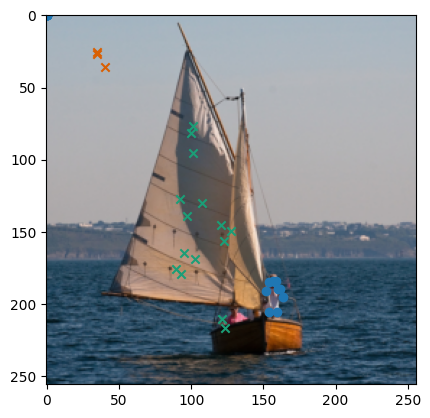

Person 1 keypoints:
tensor([[9.9934e+01, 8.1275e+01, 9.9999e-01],
        [5.3541e+01, 4.1063e+01, 1.9237e-01],
        [1.0135e+02, 7.6538e+01, 9.9999e-01],
        [2.3694e+01, 3.7133e+01, 8.1401e-03],
        [1.0119e+02, 9.5243e+01, 1.0000e+00],
        [1.2073e+02, 1.4533e+02, 1.0000e+00],
        [1.2723e+02, 1.4910e+02, 1.0000e+00],
        [9.7439e+01, 1.3901e+02, 1.0000e+00],
        [1.2298e+02, 1.5652e+02, 1.0000e+00],
        [9.2535e+01, 1.2715e+02, 1.0000e+00],
        [1.0772e+02, 1.2995e+02, 1.0000e+00],
        [9.4781e+01, 1.6441e+02, 1.0000e+00],
        [1.0291e+02, 1.6880e+02, 1.0000e+00],
        [1.2120e+02, 2.1053e+02, 1.0000e+00],
        [1.2328e+02, 2.1682e+02, 1.0000e+00],
        [8.9635e+01, 1.7557e+02, 1.0000e+00],
        [9.2767e+01, 1.7925e+02, 1.0000e+00]])
Person 2 keypoints:
tensor([[ 5.2297e+00,  9.9958e-01,  9.9797e-04],
        [ 4.5898e+00,  6.4317e-01,  1.6711e-03],
        [-2.1588e-01, -1.5834e+00,  1.5023e-04],
        [ 1.4651e+01,  9.4871e

In [ ]:
imgs, targets = next(iter(test_loader))
imgs = imgs.to(device)
with torch.no_grad():
    preds = model(imgs)

idx = random.randint(0, imgs.shape[0] - 1)
img = imgs[idx].cpu()
gt_kpts_list = targets[idx]  # (MAX_PERSONS, 17, 3)
pred_kpts_list = preds[idx].cpu()  # (MAX_PERSONS, 17, 3)

visualize_prediction(img, gt_kpts_list, pred_kpts_list)

for i, kp in enumerate(pred_kpts_list):
    print(f"Person {i+1} keypoints:\n{kp}")

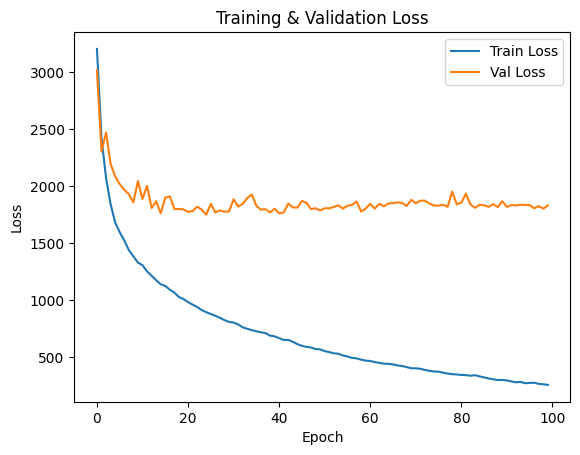

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()